# Model selection

A series of experimental runs and tweaks to test different ml models.

In [7]:
# common imports
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pandas_profiling import ProfileReport
from xgboost.sklearn import XGBRegressor
%matplotlib inline

# # Read the file from DS02
filename = '../data/N-CMAPSS_DS02.h5'

# Setup save loc for graphs
graph_folder = '../graphs/'

In [2]:
# Preprossesing as identified in EDA/prep
# # Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 

In [3]:
# defining longer more meaningful names for the variables
# Auxiliary data
auxiliary_cols = ['unit','cycle','flight_class','health_state']
df_A_train = DataFrame(data=A_dev, columns=auxiliary_cols)
df_A_test = DataFrame(data=A_test, columns=auxiliary_cols)

# Scenario descriptors
scenario_cols = ['altitude','mach_number','throttle_resolver_angle','fan_inlet_temp']
df_W_train = DataFrame(data=W_dev, columns=scenario_cols)
df_W_test = DataFrame(data=W_test, columns=scenario_cols)

# Measurements
physical_sensor_cols = [
    'fuel_flow','physical_fan_speed','physical_core_speed','lpc_temp','hpc_temp','hpt_temp','lpt_temp',
    'bypass_duct_temp','fan_in_pressure','fan_out_pressure','lpc_pressure','hpc_static_pressure','burner_out_pressure','lpt_pressure'
    ]
df_X_s_train = DataFrame(data=X_s_dev, columns=physical_sensor_cols)
df_X_s_test = DataFrame(data=X_s_test, columns=physical_sensor_cols)


# Virtual sensors
virtual_sensor_cols = [
    'total_temp_burner_outlet','total_pressure_hpc_outlet','total_pressure_hpt_outlet','fan_flow','lpc_outflow',
    'hpc_inflow','hpt_coolant_bleed','lpt_coolant_bleed','hpt_outflow','lpt_outflow','fan_stall_margin',
    'lpc_stall_margin','hpc_stall_margin','ratio_fuel_flow_to_static_hpc_pressure'
]
df_X_v_train = DataFrame(data=X_v_dev, columns=virtual_sensor_cols)
df_X_v_test = DataFrame(data=X_v_test, columns=virtual_sensor_cols)

# Health parameters
health_param_cols = [
    'fan_efficiency_mod','fan_flow_mod','lpc_efficiency_mod','lpc_flow_mod','hpc_efficiency_mod','hpc_flow_mod',
    'hpt_efficiency_mod','hpt_flow_mod','lpt_efficiency_mod','lpt_flow_mod'
]
df_T_dev = DataFrame(data=T_dev, columns=health_param_cols)
df_T_test = DataFrame(data=T_test, columns=health_param_cols)


# RUL
df_Y_train = DataFrame(data=Y_dev, columns=['RUL'])
df_Y_test = DataFrame(data=Y_test, columns=['RUL'])


# exclude df_T health parameters, health state, flight class
df_train = pd.concat([df_A_train, df_W_train, df_X_s_train, df_X_v_train, df_Y_train], axis=1).drop(['health_state', 'flight_class'], axis=1)
df_test = pd.concat([df_A_test, df_W_test, df_X_s_test, df_X_v_test, df_Y_test], axis=1).drop(['health_state', 'flight_class'], axis=1)

In [4]:
# setup simple evaluation metrics

from sklearn.metrics import mean_squared_error, r2_score

# evaluation function
def evaluate(actual, pred, label=None):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(f'{label} RMSE: {rmse:.2f} Variance: {variance:.2f}')

In [5]:
# setup pred vs actual plot
def plot_pred_vs_actual(pred, actual, label='Prediction', save=False):
    plt.plot(pred, color="green", label="Predicted")
    plt.plot(actual, color="orange", label="Actual")
    plt.title(label)
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(loc='upper right')
    if save:
        plt.savefig(graph_folder + f'model_selection_{label}.jpeg')
    plt.show()

# Rank feature importance using rf

In [6]:
# more imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
# split x_train and y_train
X_train = df_train.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train = df_train['RUL']

In [8]:
def rank_importance(x_train, y_train):
    labels = x_train.columns.values

     # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=20, random_state=0, n_jobs=-1)

    # Train the classifier
    clf.fit(x_train, y_train)

    # Plot random forest feature importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances', fontdict={'fontsize': 16})
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [labels[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    plt.savefig("../graphs/model_selection_feature_importance.jpeg")

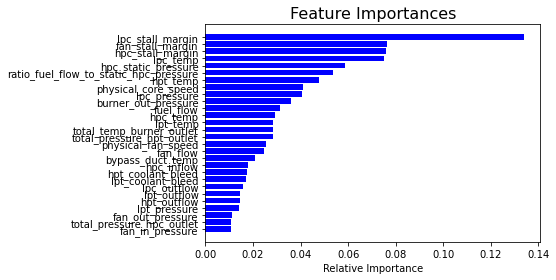

<Figure size 432x288 with 0 Axes>

In [8]:
rank_importance(X_train, y_train)

## Regression

In [10]:
from sklearn.linear_model import LinearRegression

x_train = df_train.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train = df_train['RUL']

x_test = df_test.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_test = df_test['RUL']

print(x_train.columns)

Index(['fuel_flow', 'physical_fan_speed', 'physical_core_speed', 'lpc_temp',
       'hpc_temp', 'hpt_temp', 'lpt_temp', 'bypass_duct_temp',
       'fan_in_pressure', 'fan_out_pressure', 'lpc_pressure',
       'hpc_static_pressure', 'burner_out_pressure', 'lpt_pressure',
       'total_temp_burner_outlet', 'total_pressure_hpc_outlet',
       'total_pressure_hpt_outlet', 'fan_flow', 'lpc_outflow', 'hpc_inflow',
       'hpt_coolant_bleed', 'lpt_coolant_bleed', 'hpt_outflow', 'lpt_outflow',
       'fan_stall_margin', 'lpc_stall_margin', 'hpc_stall_margin',
       'ratio_fuel_flow_to_static_hpc_pressure'],
      dtype='object')


In [11]:
# create and fit a linear regression model
lm = LinearRegression()
lm.fit(x_train, y_train)

# predict and evaluate
y_pred_train = lm.predict(x_train)
evaluate(y_train, y_pred_train, label='train')

y_pred_test = lm.predict(x_test)
evaluate(y_test, y_pred_test, label='test')

train RMSE: 11.49 Variance: 0.74
test RMSE: 11.39 Variance: 0.64


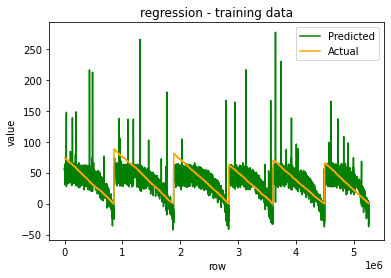

In [12]:
# plot the results - training data
plot_pred_vs_actual(y_pred_train, y_train, label='regression - training data')

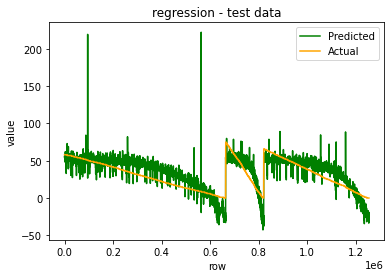

In [13]:
# plot the results - test data
plot_pred_vs_actual(y_pred_test, y_test, label='regression - test data')

The linear regression model fits based on the assumption that RUL declines linearly over time. However based on the two graphs above, the actual RUL decline is non-linear. There is a clear indication of the engines seperately, and the actual RUL pattern shows that decline is near-constant at the start but declines more rapidly later (i.e., once the fault has been introduced).

# Lag features

Lag features are added because in time-series analysis, past values can influence the future trend. 
Ref https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0#:~:text=or%20future%20periods.-,Lag%20features%20and%20window%20features,intrinsic%20information%20about%20the%20future.
 

In [8]:
def add_lag(og_df, name):
    df = og_df.copy()
    df['RUL_lag1'] = df['RUL'].shift(1)
    df['RUL_lag3'] = df['RUL'].shift(3)
    df['RUL_lag5'] = df['RUL'].shift(5)
    df = df.iloc[5::] # remove NaNs

    fig = df.plot(
        y=['RUL', 'RUL_lag1', 'RUL_lag3', 'RUL_lag5'],
        kind="line",
        figsize=(15, 5),
        title='RUL with lagged values',
        xlabel='index',
        use_index=True,
        linewidth=1.0,
        alpha=0.7,
        xlim=(0, df.index.max())).get_figure()

    fig.savefig(f"../graphs/{name}_model_selection_lag.jpeg")
    return df

# df_train_lagged = add_lag(df_train, 'train')
# df_test_lagged = add_lag(df_test, 'test')

# Linear regression with lagged RUL

In [17]:
x_train_lagged = df_train_lagged.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train_lagged = df_train_lagged['RUL']

x_test_lagged = df_test_lagged.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_test_lagged = df_test_lagged['RUL']

In [18]:
lm = LinearRegression()
lm.fit(x_train_lagged, y_train_lagged)

# predict and evaluate
y_pred_train_lagged = lm.predict(x_train_lagged)
evaluate(y_train_lagged, y_pred_train_lagged, label='train')

y_pred_test_lagged = lm.predict(x_test_lagged)
evaluate(y_test_lagged, y_pred_test_lagged, label='test')

train RMSE: 0.07 Variance: 1.00
test RMSE: 0.09 Variance: 1.00


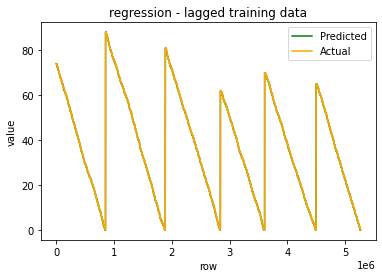

In [19]:
plot_pred_vs_actual(y_pred_train_lagged, y_train_lagged, label='regression - lagged training data')

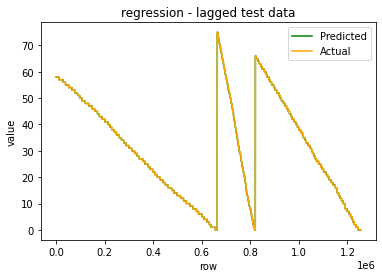

In [20]:
plot_pred_vs_actual(y_pred_test_lagged, y_test_lagged, label='regression - lagged test data')

# Ridge regression

Now we have two sets of test and train dfs - lagged and original. 

* Original train - x_train, y_train
* Original test - x_test, y_test
* Lagged train - x_train_lagged, y_train_lagged
* Lagged test - x_test_lagged, y_test_lagged

In [ ]:
x_train = df_train.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train = df_train['RUL']

x_test = df_test.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_test = df_test['RUL']

df_train_lagged = add_lag(df_train, 'train')
df_test_lagged = add_lag(df_test, 'test')

x_train_lagged = df_train_lagged.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_train_lagged = df_train_lagged['RUL']

x_test_lagged = df_test_lagged.drop(['RUL','unit', 'cycle','altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'], axis=1)
y_test_lagged = df_test_lagged['RUL']

In [14]:
from sklearn.linear_model import Ridge

def ridge_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix, alpha=1.0):
    # create and fit a ridge regression model
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)

    # predict and evaluate
    y_pred_train = ridge.predict(x_train)
    evaluate(y_train, y_pred_train, label=f'{label_prefix}_train')

    y_pred_test = ridge.predict(x_test)
    evaluate(y_test, y_pred_test, label=f'{label_prefix}_test')

    # plot the results - training data
    plot_pred_vs_actual(y_pred_train, y_train, label=f'{label_prefix}_ridge - training data')

    # plot the results - test data
    plot_pred_vs_actual(y_pred_test, y_test, label=f'{label_prefix}_ridge - test data')

original_train RMSE: 11.50 Variance: 0.74
original_test RMSE: 11.37 Variance: 0.64


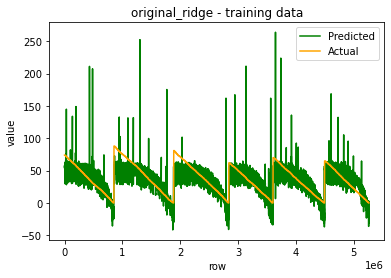

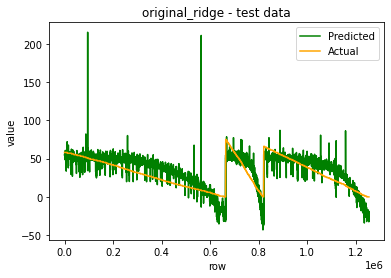

In [15]:
ridge_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix='original')

lagged_train RMSE: 0.07 Variance: 1.00
lagged_test RMSE: 0.09 Variance: 1.00


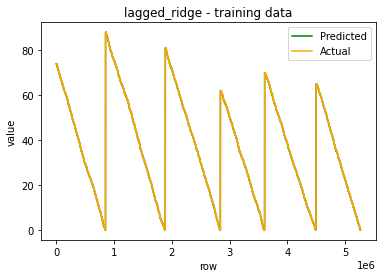

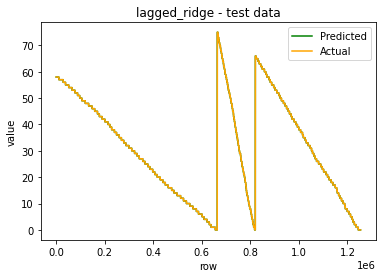

In [16]:
ridge_evaluate_and_plot(x_train_lagged, y_train_lagged, x_test_lagged, y_test_lagged, label_prefix='lagged')

original_train RMSE: 11.49 Variance: 0.74
original_test RMSE: 11.39 Variance: 0.64


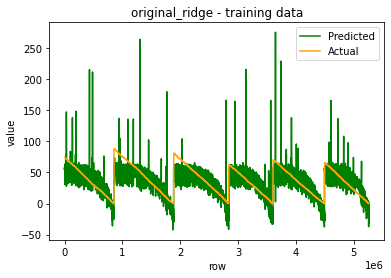

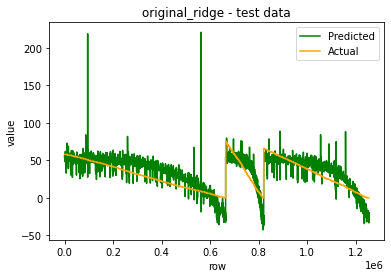

In [17]:
ridge_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix='original', alpha=0.1)

original_train RMSE: 11.54 Variance: 0.73
original_test RMSE: 11.34 Variance: 0.64


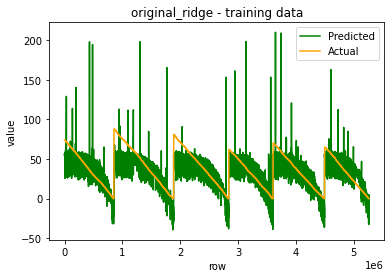

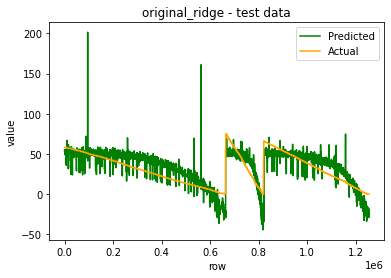

In [18]:
ridge_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix='original', alpha=10.0)

# Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix, n_estimators=20):
    # create and fit a random forest regression model
    rf = RandomForestRegressor(n_estimators=n_estimators)
    rf.fit(x_train, y_train)

    # predict and evaluate
    y_pred_train = rf.predict(x_train)
    evaluate(y_train, y_pred_train, label=f'{label_prefix}_train')

    y_pred_test = rf.predict(x_test)
    evaluate(y_test, y_pred_test, label=f'{label_prefix}_test')

    # plot the results - training data
    plot_pred_vs_actual(y_pred_train, y_train, label=f'{label_prefix}_random_forest - training data')

    # plot the results - test data
    plot_pred_vs_actual(y_pred_test, y_test, label=f'{label_prefix}_random_forest - test data')

original_train RMSE: 1.42 Variance: 1.00
original_test RMSE: 9.05 Variance: 0.77


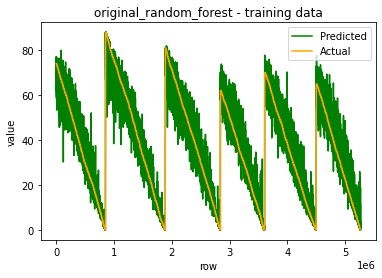

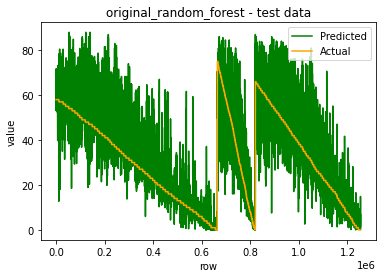

In [23]:
random_forest_evaluate_and_plot(x_train, y_train, x_test, y_test, label_prefix='original')

lagged_train RMSE: 0.02 Variance: 1.00
lagged_test RMSE: 0.10 Variance: 1.00


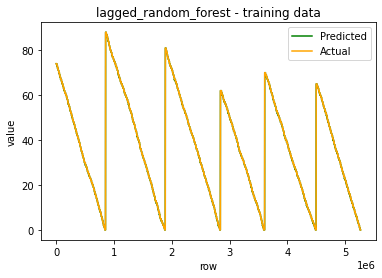

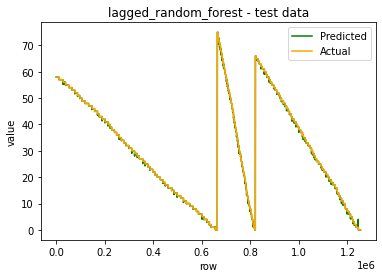

In [24]:
random_forest_evaluate_and_plot(x_train_lagged, y_train_lagged, x_test_lagged, y_test_lagged, label_prefix='lagged')